In [1]:
from search_clustering.pipeline import *
from search_clustering.client import *
from search_clustering.preprocessing import *
from search_clustering.embedding import *
from search_clustering.reduction import *
from search_clustering.clustering.knn import *
from search_clustering.clustering.temporal import *
from search_clustering.labeling import *

In [2]:
import json

query = "energie"
samples = 100
use_cached_data = True

if not use_cached_data:
    es = ElasticClient()

    for index in es.client.indices.get_alias():
        print(index)

    results = es.search(index="faz", field="body", query=query, size=1_000)

    with open(f"datasets/results_{query}.json", "w") as json_file:
        json.dump(results, json_file)


with open(f"datasets/results_{query}.json", "r") as json_file:
    results = json.load(json_file)
    results = [
        res for res in results if res["_source"]["publication_date"] is not None
    ][:samples]


print(f"{len(results)} results")
# snippets = [res["snippet"] for res in results]
# bodies = [res["_source"]["body"] for res in results]
# titles = [res["_source"]["title"] for res in results]
# timestamps = [res["_source"]["publication_date"] for res in results]

100 results


In [ ]:
pipe = SpatialPipeline(
    DummyPreprocessor(),
    SentenceMiniLM("body"),
    Umap(32),
    DummyClustering(),
    DummyLabeling(),
)

pipe.fit_transform(results, title="MiniLM + UMAP")

In [ ]:
pipe = SpatialPipeline(
    ParagraphKeyphraseExtractor(),
    SentenceMiniLM("topics"),
    UMAP(),
    HDBSCAN(),
    Topically(),
)

print(f"Query: {query}")
docs, clusters, labels = pipe.run(results, visualize=True)

cache = [clusters, labels]
cluster = results

while True:
    max_i = max(list(clusters), key=list(clusters).count)
    cluster = [cluster[i] for i in np.where(clusters == max_i)[0]]
    if len(cluster) < 10:
        break
    print(labels[max_i])
    docs, clusters, labels = pipe.run(cluster, visualize=True, verbose=False)

In [ ]:
from datetime import datetime

for j in range(max(cache[0])):
    indices = np.where(cache[0] == j)[0]
    timestamps = [results[i]["_source"]["publication_date"] for i in indices]
    timestamps = [datetime.strptime(stamp, "%Y-%m-%d %H:%M:%S") for stamp in timestamps]
    plt.scatter(
        timestamps,
        [len(cache[1]) - j - 1 for _ in range(len(timestamps))],
        label=cache[1][j],
    )

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
scores = [doc["_score"] for doc in results]

plt.plot(scores)
plt.show()

for j in set(clusters[0]):
    idx = np.where(clusters[0] == j)[0]
    cluster_docs = [results[i] for i in idx]
    scores = [doc["_score"] for doc in cluster_docs]
    plt.scatter([j for _ in range(len(scores))], scores, label=cache[1][j])

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

timestamps = [res["_source"]["publication_date"][:10] for res in results]

df = pd.DataFrame(pd.to_datetime(timestamps), columns=["date"])

first_day = df.date.min()
last_day = df.date.max()
timespan = last_day - first_day
interval = timedelta(30)
bins = 10  # timespan // interval
real_interval = timespan / bins

hist = list(pd.np.histogram(df["date"].astype(int), bins=bins, density=False))
diff = abs(np.diff(hist[0]))

plt.figure(figsize=(5, 4))
plt.bar(range(bins), hist[0], label=r"$h_i$")
plt.bar(np.arange(bins - 1) + 1, np.clip(diff, 0, np.inf), label=r"$|\Delta h_i |$")
plt.plot(range(bins), [np.mean(diff) for _ in range(bins)], color="C2", linewidth=2)
plt.bar(0, 0, color="C2", label=r"mean $|\Delta h_i |$")
plt.xticks(range(0, 10), xlabels[::1], rotation=90)
plt.yticks(range(0, 21, 2))
plt.legend()
plt.show()

In [ ]:
colors = ["C0", "C0", "C0", "C1", "C2", "C2", "C2", "C2", "C3", "C3"]

plt.figure(figsize=(5, 4))
plt.bar(range(bins), hist[0], color=colors, label=r"$c_1$")
plt.bar(0, 0, color="C1", label=r"$c_2$")
plt.bar(0, 0, color="C2", label=r"$c_3$")
plt.bar(0, 0, color="C3", label=r"$c_4$")
plt.xticks(range(0, 10), xlabels[::1], rotation=90)
plt.yticks(range(0, 21, 2))
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

timestamps = [res["_source"]["publication_date"][:10] for res in results]

df = pd.DataFrame(pd.to_datetime(timestamps), columns=["date"])

first_day = df.date.min()
last_day = df.date.max()
timespan = last_day - first_day
interval = timedelta(30)
bins = 10  # timespan // interval
real_interval = timespan / bins

xlabels = [str(first_day + i * real_interval)[:10] for i in range(bins)]

hist = list(pd.np.histogram(df["date"].astype(int), bins=bins, density=False))
diff = abs(np.gradient(hist[0]))

plt.figure(figsize=(5, 4))
plt.bar(range(bins), hist[0], label=r"$h_i$")
plt.bar(range(bins), np.clip(diff, 0, np.inf), label=r"$|\partial h_i |$")
plt.plot(range(bins), [np.mean(diff) for _ in range(bins)], color="C2", linewidth=2)
plt.bar(0, 0, color="C2", label=r"mean $|\partial h_i |$")
plt.xticks(range(0, 10), xlabels[::1], rotation=90)
plt.yticks(range(0, 21, 2))
plt.legend()
plt.show()

In [ ]:
colors = ["C0", "C0", "C1", "C1", "C2", "C2", "C2", "C3", "C3", "C4"]

plt.figure(figsize=(5, 4))
plt.bar(range(bins), hist[0], color=colors, label=r"$c_1$")
plt.bar(0, 0, color="C1", label=r"$c_2$")
plt.bar(0, 0, color="C2", label=r"$c_3$")
plt.bar(0, 0, color="C3", label=r"$c_4$")
plt.bar(0, 0, color="C4", label=r"$c_5$")
plt.xticks(range(0, 10), xlabels[::1], rotation=90)
plt.yticks(range(0, 21, 2))
plt.legend()
plt.show()

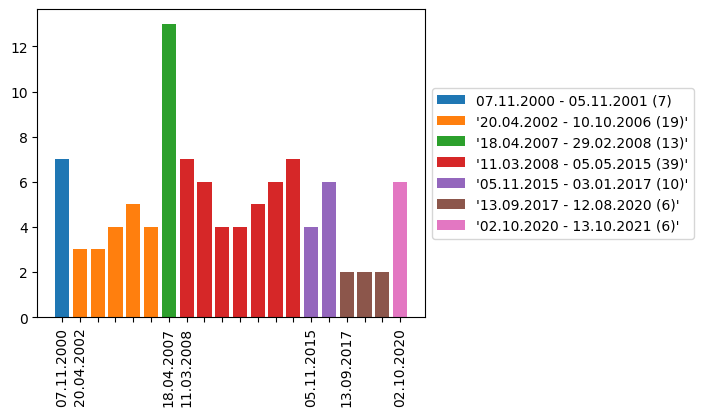

In [4]:
tpipe = TemporalPipeline(
    DummyPreprocessor(),
    TemporalClustering(target_bins=20, window_size=0),
    TemporalLabeling(),
)
docs, clusters1, labels = tpipe.fit_transform(results, verbose=False)

In [ ]:
def get_colors(hist, clusters):
    colors = list(hist[0])
    print(type(hist[0]))

    count_in_cluster = 0
    s = 0

    for i in range(len(color)):
        s += color[i]
        color[i] = f"C{c}"
        if s >= len(clusters[clusters == c]):
            c += 1
            s = 0

    return color

In [ ]:
tpipe = TemporalPipeline(
    DummyPreprocessor(),
    TemporalClustering(target_bins=8, window_size="auto"),
    TemporalLabeling(),
)
docs, clusters2, labels = tpipe.run(results, verbose=False)

colors = get_colors(hist, clusters2)
plt.bar(range(bins), hist[0], color=colors)
plt.show()

for label in labels:
    print(label)

In [ ]:
from nltk.tokenize import word_tokenize

n_tokens = []

for i in range(len(results)):
    r = results[i]["_source"]["body"]
    n_tokens.append(len(word_tokenize(r)))

d = describe(n_tokens)

pd.DataFrame(n_tokens).hist(bins=20)